In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", path)


100%|██████████| 3.04G/3.04G [00:35<00:00, 91.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pypiahmad/realistic-action-recognition-ucf50/versions/1


In [4]:
# Define the 18 selected action classes
selected_classes = [
    "Basketball",
    "Diving",
    "HorseRace",
    "JumpRope",
    "VolleyballSpiking",
    "WalkingWithDog",
    "BenchPress",
    "Biking",
    "GolfSwing",
    "HighJump",
    "Kayaking",
    "PullUps",
    "PushUps",
    "RopeClimbing",
    "SkateBoarding",
    "SoccerJuggling",
    "Swing",
    "TrampolineJumping"
]

# UCF50 dataset path
dataset_path = os.path.join(path, "UCF50")

# Confirm folder structure
for cls in selected_classes:
    print(f"{cls} → Total videos:", len(os.listdir(os.path.join(dataset_path, cls))))

Basketball → Total videos: 137
Diving → Total videos: 153
HorseRace → Total videos: 127
JumpRope → Total videos: 148
VolleyballSpiking → Total videos: 116
WalkingWithDog → Total videos: 123
BenchPress → Total videos: 160
Biking → Total videos: 145
GolfSwing → Total videos: 142
HighJump → Total videos: 123
Kayaking → Total videos: 157
PullUps → Total videos: 120
PushUps → Total videos: 106
RopeClimbing → Total videos: 130
SkateBoarding → Total videos: 120
SoccerJuggling → Total videos: 156
Swing → Total videos: 137
TrampolineJumping → Total videos: 119


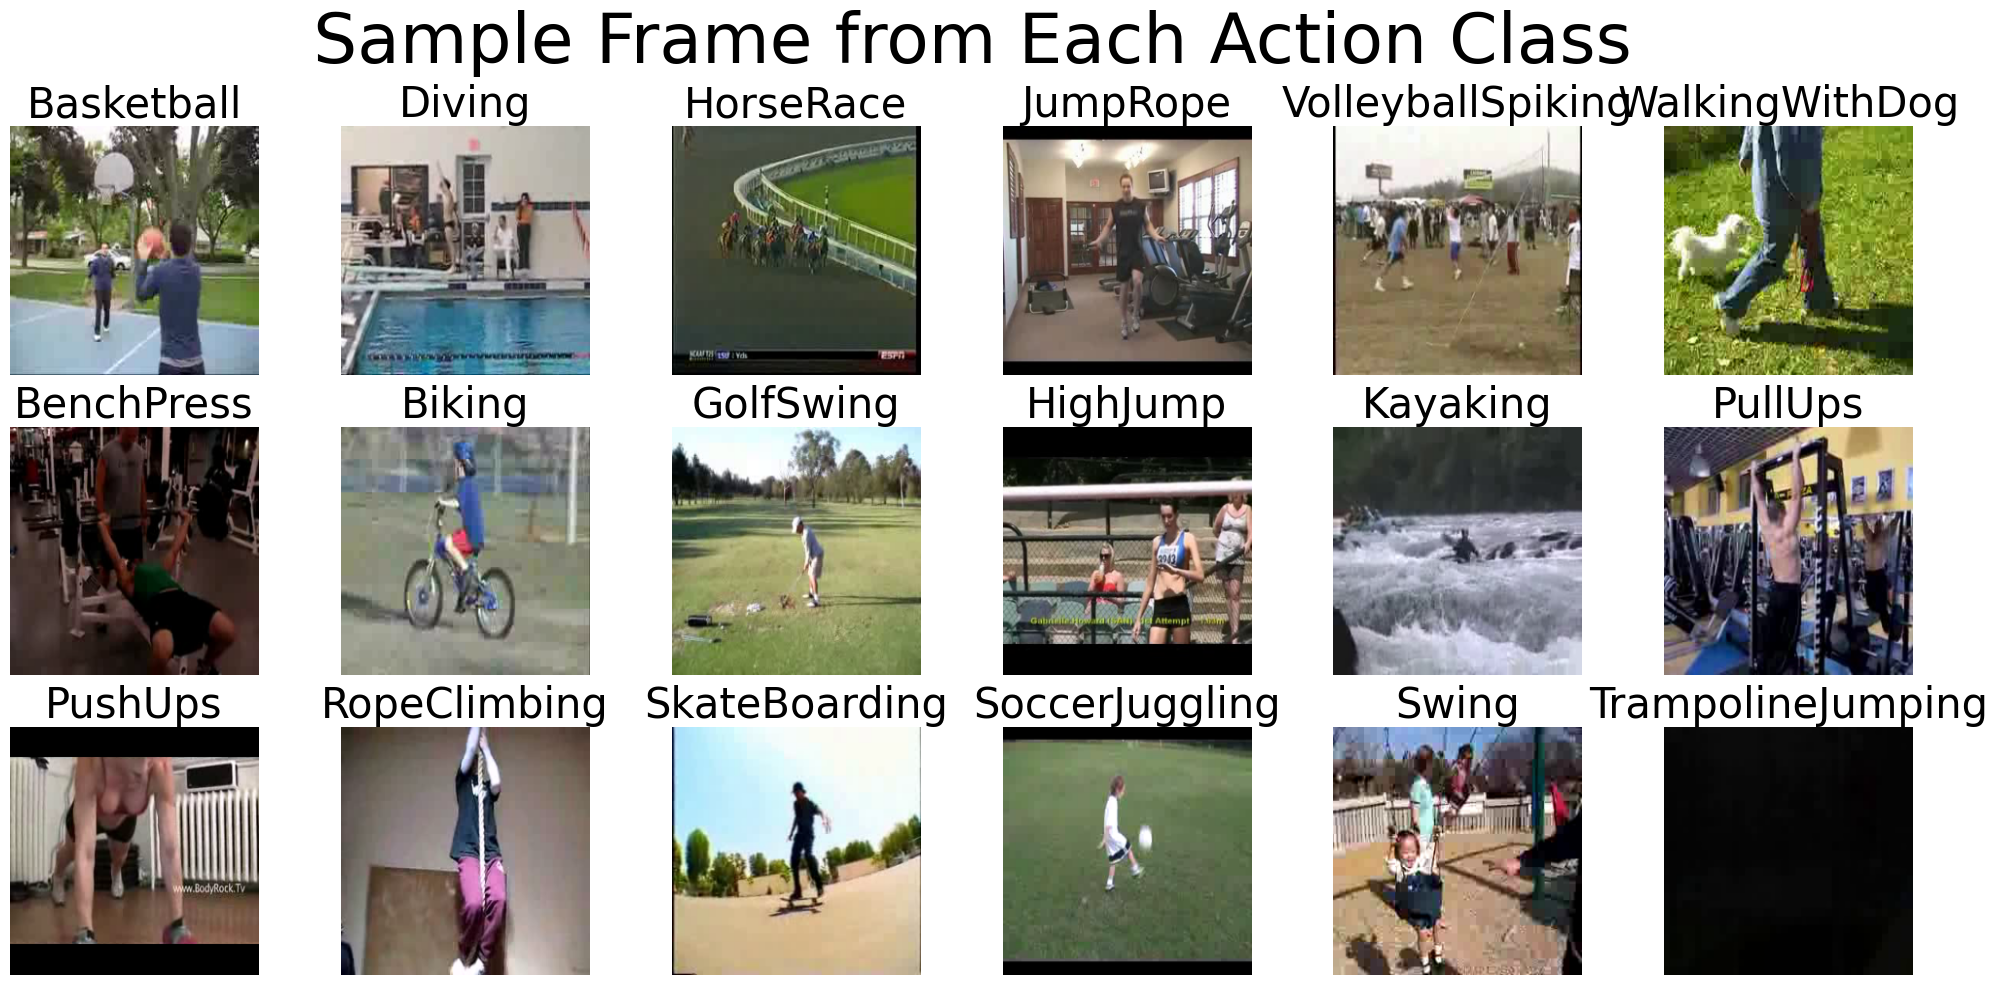

In [5]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame)
            axes[i].set_title(cls , fontsize = 30)
        axes[i].axis('off')

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, dataset_path)

## Applying the Augmentation

In [11]:
import albumentations as A

video_augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.GaussianBlur(p=0.1),
])


## Extract Frames

In [12]:
import cv2
import numpy as np

def extract_frames(video_path, num_frames=20, augment=False):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_interval = max(total_frames // num_frames, 1)
    frames = []
    count = 0

    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_interval == 0:
            frame = cv2.resize(frame, (64, 64))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply augmentation only during training
            if augment:
                frame = video_augmenter(image=frame)["image"]

            frame = frame / 255.0
            frames.append(frame)

        count += 1

    cap.release()

    # Pad short videos
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)


In [13]:
def video_generator(class_list, dataset_path, batch_size=4, num_frames=20, augment=False):
    while True:
        X_batch = []
        y_batch = []

        for _ in range(batch_size):
            cls_idx = np.random.randint(0, len(class_list))
            cls = class_list[cls_idx]
            class_path = os.path.join(dataset_path, cls)

            video = np.random.choice(os.listdir(class_path))
            video_path = os.path.join(class_path, video)

            frames = extract_frames(video_path, num_frames, augment=augment)

            X_batch.append(frames)
            y_batch.append(cls_idx)

        X_batch = np.array(X_batch)
        y_batch = to_categorical(y_batch, num_classes=len(class_list))

        yield X_batch, y_batch


In [14]:
#  Model = CNN applied on each frame using TimeDistributed + LSTM for sequence learning

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(20, 64, 64, 3)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Flatten()))

# LSTM layer for temporal patterns
model.add(LSTM(64))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(18, activation='softmax'))  # 18 classes

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

train_gen = video_generator(
    selected_classes, dataset_path,
    batch_size=8, num_frames=20, augment=True
)
val_gen = video_generator(
    selected_classes, dataset_path,
    batch_size=8, num_frames=20, augment=False
)

steps_per_epoch = 200   # you can increase
validation_steps = 40

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=[early_stopping]
)


Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 497ms/step - accuracy: 0.0848 - loss: 2.9070 - val_accuracy: 0.3344 - val_loss: 2.3181
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 714ms/step - accuracy: 0.2826 - loss: 2.4112 - val_accuracy: 0.4688 - val_loss: 1.9380
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 96s 484ms/step - accuracy: 0.3730 - loss: 2.0538 - val_accuracy: 0.5750 - val_loss: 1.5193
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 475ms/step - accuracy: 0.5099 - loss: 1.6516 - val_accuracy: 0.6094 - val_loss: 1.3161
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 474ms/step - accuracy: 0.5530 - loss: 1.4929 - val_accuracy: 0.6938 - val_loss: 1.1122
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 139s 700ms/step - accuracy: 0.6218 - loss: 1.2787 - val_accuracy: 0.7469 - val_loss: 0.8699
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 473ms/step - accuracy: 0.7068 - loss: 1.0751 - val_accuracy: 0.7812 - val_loss: 0.8244
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 475ms/step - accuracy: 0.7079 - loss

In [16]:
model.save('action_recognition_model_CNN_LSTM_with_Augmentation.h5')
print("Model saved successfully to 'action_recognition_model_CNN_LSTM_with_Augmentation.h5'")

Model saved successfully to 'action_recognition_model_CNN_LSTM_with_Augmentation.h5'


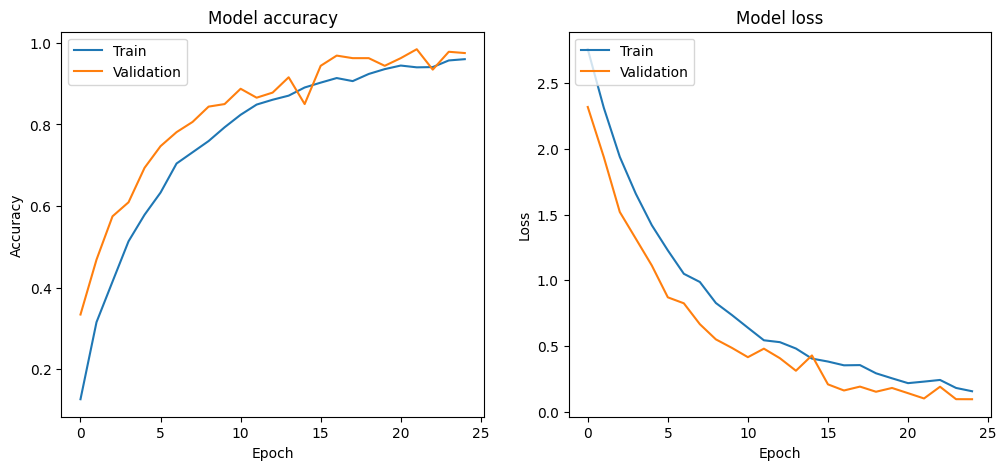

In [17]:
import matplotlib.pyplot as plt

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

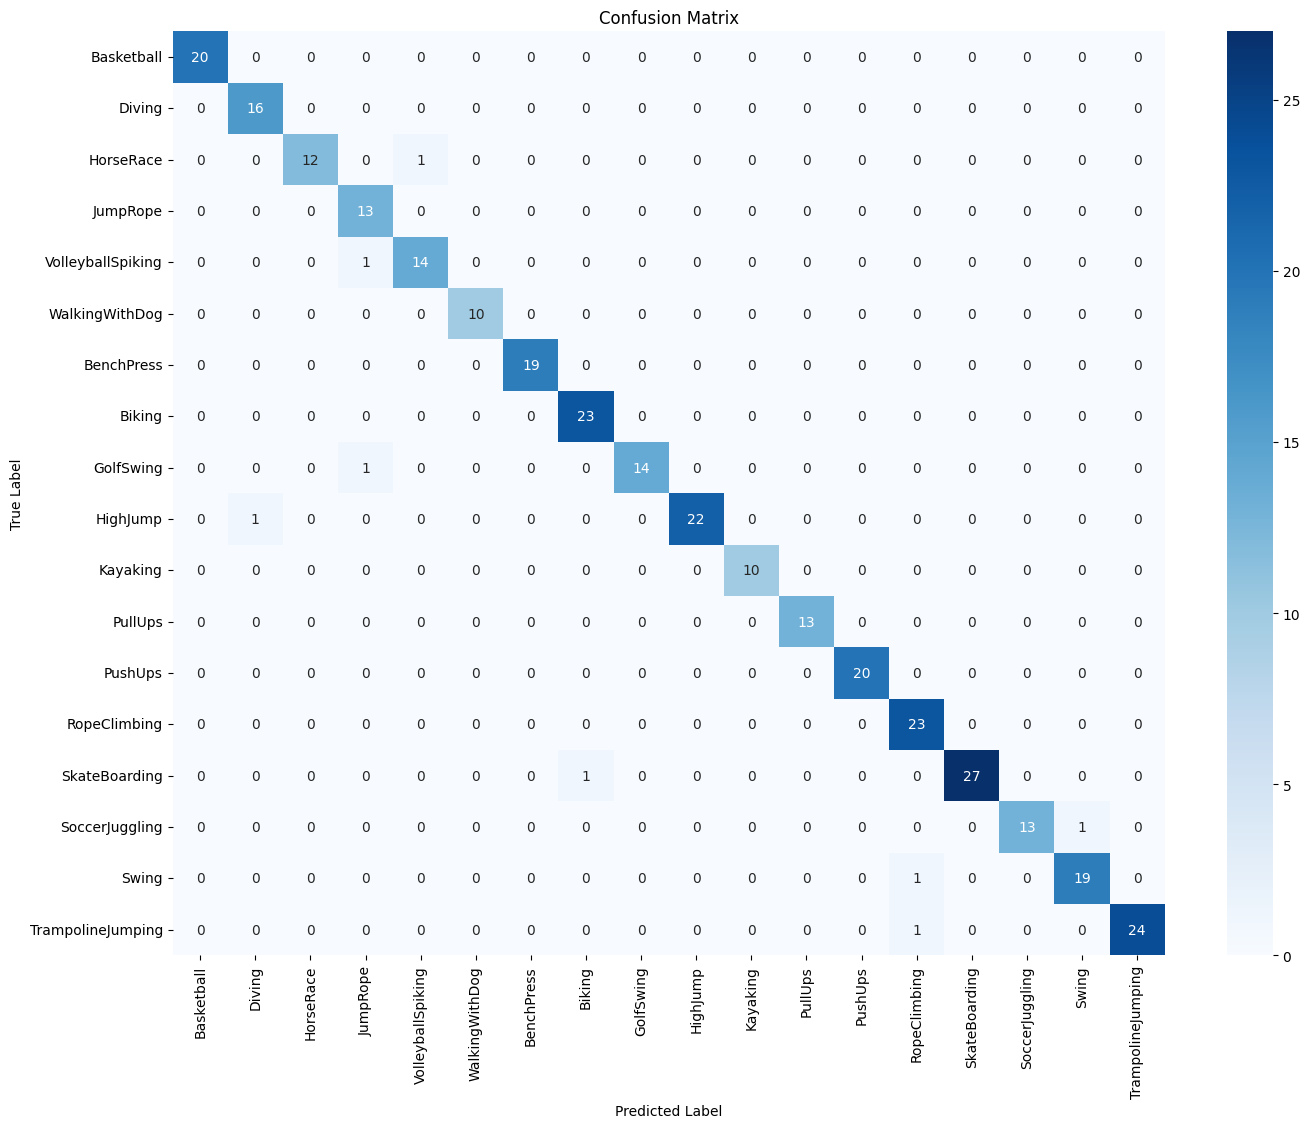

In [19]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

batch_size = 8
validation_steps = 40
# Reset the validation generator to get a fresh set of data
val_gen_cm = video_generator(selected_classes, dataset_path, batch_size=batch_size)

# Collect true labels and predictions
all_true_labels = []
all_predictions = []

for _ in range(validation_steps):
    X_val_batch, y_val_batch = next(val_gen_cm)

    # Get predictions for the current batch
    predictions_batch = model.predict(X_val_batch)

    # Convert one-hot encoded true labels to class indices
    true_labels_batch = np.argmax(y_val_batch, axis=1)

    # Convert predictions to class indices
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)

    all_true_labels.extend(true_labels_batch)
    all_predictions.extend(predicted_labels_batch)

# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()